In [4]:
import os
import numpy as np
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import IPython.display as ipd
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.chdir("/content/gdrive/MyDrive/mandarin2.mp3")
!ls

In [7]:
#TRAIN_PATH = '../input/audio_train/'
ipd.Audio("/content/gdrive/MyDrive/mandarin2.mp3")

In [11]:
sample_rate, audio = wavfile.read("/content/gdrive/MyDrive/mandarin2.wav")
print("Sample rate: {0}Hz".format(sample_rate))
print("Audio duration: {0}s".format(len(audio) / sample_rate))

Sample rate: 44100Hz
Audio duration: 38.306009070294785s


In [13]:
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

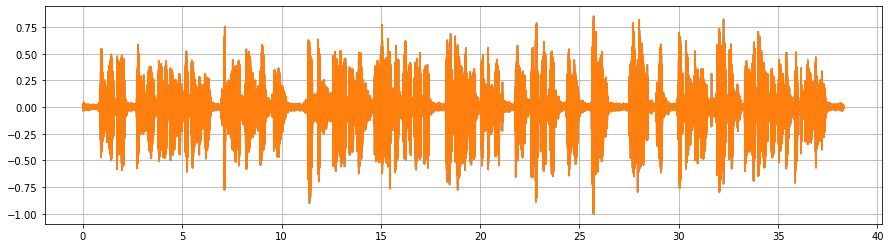

In [14]:
audio = normalize_audio(audio)
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.grid(True)

In [15]:
def frame_audio(audio, FFT_size=2048, hop_size=10, sample_rate=44100):
    # hop_size in ms
    
    audio = np.pad(audio, int(FFT_size / 2), mode='reflect')
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num,FFT_size))
    
    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+FFT_size]
    
    return frames

In [ ]:
hop_size = 15 #ms
FFT_size = 2048

audio_framed = frame_audio(audio, FFT_size=FFT_size, hop_size=hop_size, sample_rate=sample_rate)
print("Framed audio shape: {0}".format(audio_framed.shape))

In [ ]:
print("First frame:")
audio_framed[1]

In [ ]:
print("Last frame:")
audio_framed[-1]

In [ ]:
window = get_window("hann", FFT_size, fftbins=True)
plt.figure(figsize=(15,4))
plt.plot(window)
plt.grid(True)

In [ ]:
audio_win = audio_framed * window

ind = 69
plt.figure(figsize=(15,6))
plt.subplot(2, 1, 1)
plt.plot(audio_framed[ind])
plt.title('Original Frame')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(audio_win[ind])
plt.title('Frame After Windowing')
plt.grid(True)

In [ ]:
def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters

In [ ]:
filters = get_filters(filter_points, FFT_size)

plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

In [ ]:
enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
filters *= enorm[:, np.newaxis]

In [ ]:
plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

audio_filtered = np.dot(filters, np.transpose(audio_power))
audio_log = 10.0 * np.log10(audio_filtered)
audio_log.shape

In [ ]:
def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
    return basis

In [ ]:
dct_filter_num = 40

dct_filters = dct(dct_filter_num, mel_filter_num)

cepstral_coefficents = np.dot(dct_filters, audio_log)
cepstral_coefficents.shape

In [ ]:
cepstral_coefficents[:, 0]

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.imshow(cepstral_coefficents, aspect='auto', origin='lower');